# Group 7: Mobility Innovators (Visitors Model)

Group Members:

- Aquiles Escarra
- Inderjeet Singh
- Aditya Mehta
- Yungvir Singh

## Parking Occupancy Prediction – Banff Mobility Project (Visitors Model)

This notebook forms part of the modeling pipeline used for the Banff Mobility Project.
It documents the complete development workflow for the Visitor Parking Occupancy Model, including data preprocessing, feature generation, model training, evaluation, and explainability analysis.

Objective:
Predict hourly parking occupancy for visitors using temporal, climatic, and tourism-driven variables to support operational planning and optimize parking availability.

### Context & Data Sources

Visitors in Banff exhibit mobility patterns that are highly influenced by tourism cycles, weather conditions, and seasonal events.
To accurately model this behavior, the following external datasets and engineered variables were integrated into the modeling pipeline:

- Environment and Natural Resources – Government of Canada

Hourly weather conditions (temperature, precipitation, visibility) were incorporated to capture tourism sensitivity to environmental changes.

- Python holidays library

Automatically generated statutory holidays for:

- Alberta (AB)

- British Columbia (BC)

- United States (US)

Holidays significantly increase visitor inflows, especially long weekends.

- Custom event indicators

Given the strong tourism character of Banff, two special events were added:

- is_spring_break – captures peak influx from Canadian and US school breaks

- is_stampede – models tourism spikes linked to Calgary Stampede overflow

These features help the model detect atypical surges in visitor volume.

### Modeling Approach

We first trained a baseline Linear Regression model using a non-collinear feature set to establish reference performance and interpretability.

We then evaluated two advanced ensemble regressors:

• Random Forest Regressor

Provided strong baseline performance and robustness to noisy variables.

• XGBoost Regressor

Consistently achieved the best predictive accuracy due to its ability to model complex, non-linear relationships present in tourist behavior.

To ensure the final model was efficient for real-time deployment, hyperparameter tuning was performed using a simplified and optimized feature subset.
This reduced computational cost while maintaining high forecasting quality.

# 1. Library Imports

In [ ]:
# --- Core packages ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import plotly.graph_objects as go
import xgboost as xgb
import json


# 2. Load and Explore Data

In [ ]:
# --- Load datasets ---
df_ml = pd.read_csv("banff_parking_ml_ready_visitors.csv")

# --- Quick inspection ---
print(df_ml.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10447 entries, 0 to 10446
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   datetime                      10447 non-null  object 
 1   vehicles_count                10447 non-null  int64  
 2   hour                          10447 non-null  int64  
 3   day_of_week_num               10447 non-null  int64  
 4   is_weekend                    10447 non-null  int64  
 5   max_temp                      10447 non-null  float64
 6   min_temp                      10447 non-null  float64
 7   mean_temp                     10447 non-null  float64
 8   total_precip                  10447 non-null  float64
 9   snow_on_ground                10447 non-null  float64
 10  month                         10447 non-null  int64  
 11  target_lag3                   10447 non-null  float64
 12  target_lag24                  10447 non-null  float64
 13  t

In [ ]:
df_ml.head()

,datetime,vehicles_count,hour,day_of_week_num,is_weekend,max_temp,min_temp,mean_temp,total_precip,snow_on_ground,...,EastEntrance_Southbound_lag3,MountainAve_Northbound_lag3,MountainAve_Southbound_lag3,WestEntrance_Northbound_lag3,WestEntrance_Southbound_lag3,rolling_mean_3h,rolling_std_24h,total_downtown_inflow_lag3,total_downtown_outflow_lag3,total_traffic_volume_lag3
0,2024-01-08 19:00:00,114,19,0,0,-8.1,-23.9,-16.0,0.0,16.0,...,197.0,78.0,74.0,256.0,322.0,164.000000,109.574994,814.0,773.0,1587.0
1,2024-01-08 20:00:00,80,20,0,0,-8.1,-23.9,-16.0,0.0,16.0,...,217.0,64.0,52.0,260.0,367.0,163.333333,104.859292,898.0,846.0,1744.0
2,2024-01-08 21:00:00,1,21,0,0,-8.1,-23.9,-16.0,0.0,16.0,...,222.0,70.0,40.0,231.0,266.0,153.000000,99.589584,787.0,832.0,1619.0
3,2024-01-08 22:00:00,1,22,0,0,-8.1,-23.9,-16.0,0.0,16.0,...,128.0,55.0,28.0,127.0,154.0,138.666667,95.315485,503.0,516.0,1019.0
4,2024-01-08 23:00:00,1,23,0,0,-8.1,-23.9,-16.0,0.0,16.0,...,83.0,38.0,25.0,96.0,78.0,111.000000,93.372520,289.0,375.0,664.0


In [ ]:
df_ml['datetime'] = pd.to_datetime(df_ml['datetime'])
df_ml.set_index('datetime', inplace=True)

# 5. Feature Selection

In [ ]:
# 2. FEATURE SELECTION FOR LINEAR REGRESSION
# -------------------------------------------------------------------------
# Goal: Remove redundancy so Linear Regression behaves well.

target = 'vehicles_count'

# A. Temporal Features & Binary Flags (We keep these)
feats_time = [
    'hour', 'day_of_week_num', 'month',
    'is_weekend'
]

# B. Weather Features (Choose representatives to avoid redundancy)
# Max, Min, and Mean temperatures move together → keep only Mean Temp.
feats_weather = [
    'mean_temp', 'total_precip', 'snow_on_ground'
]

# C. Historical Features (LAGS) – The most important ones!
feats_lags = [
    'target_lag3', 'target_lag24', 'target_lag168',
    'rolling_mean_3h'
]

# D. Traffic Features (AGGREGATED instead of individual lanes)
# For Linear Regression, aggregated metrics avoid perfect collinearity
# and reduce noise compared to individual directional counts.
feats_traffic = [
    'total_downtown_inflow_lag3',
    'total_downtown_outflow_lag3',
    'total_traffic_volume_lag3',
    'MountainAve_Southbound_lag3',
    'EastEntrance_Southbound_lag3'
]

# FINAL FEATURE LIST (X)
feature_cols = feats_time + feats_weather + feats_lags + feats_traffic

print(f"📊 Selected Features for Baseline ({len(feature_cols)}):")
print(feature_cols)

# Create X and y
X = df_ml[feature_cols]
y = df_ml[target]


📊 Selected Features for Baseline (16):
['hour', 'day_of_week_num', 'month', 'is_weekend', 'mean_temp', 'total_precip', 'snow_on_ground', 'target_lag3', 'target_lag24', 'target_lag168', 'rolling_mean_3h', 'total_downtown_inflow_lag3', 'total_downtown_outflow_lag3', 'total_traffic_volume_lag3', 'MountainAve_Southbound_lag3', 'EastEntrance_Southbound_lag3']


In [ ]:
# --- Split 80/20 chronologically ---
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [ ]:
# DEFINE THE FULL FEATURE SET (TREE-FRIENDLY)
# -----------------------------------------------------------
# Recover all available columns from your original dataframe,
# but remove the target and datetime columns.

# Columns to IGNORE (Non-predictive or Target)
cols_ignore = ['vehicles_count', 'datetime']  # Adjust if you have others

# Select all numerical columns
X_full = df_ml.drop(columns=cols_ignore, errors='ignore').select_dtypes(include=[np.number])

print(f"📊 Total Features for Random Forest: {X_full.shape[1]}")
print(X_full.columns.tolist())

# 2. TRAIN/TEST SPLIT WITH FULL FEATURE SET
# -----------------------------------------------------------
# Use the same time-based split to compare apples to apples
split_idx = int(len(X_full) * 0.8)
X_train_full = X_full.iloc[:split_idx]
y_train_full = y.iloc[:split_idx]

X_test_full = X_full.iloc[split_idx:]
y_test_full = y.iloc[split_idx:]

📊 Total Features for Random Forest: 25
['hour', 'day_of_week_num', 'is_weekend', 'max_temp', 'min_temp', 'mean_temp', 'total_precip', 'snow_on_ground', 'month', 'target_lag3', 'target_lag24', 'target_lag168', 'Bridge_Northbound_lag3', 'Bridge_Southbound_lag3', 'EastEntrance_Northbound_lag3', 'EastEntrance_Southbound_lag3', 'MountainAve_Northbound_lag3', 'MountainAve_Southbound_lag3', 'WestEntrance_Northbound_lag3', 'WestEntrance_Southbound_lag3', 'rolling_mean_3h', 'rolling_std_24h', 'total_downtown_inflow_lag3', 'total_downtown_outflow_lag3', 'total_traffic_volume_lag3']


# 6. Baseline & Tuned Models

## Linear Regression (Baseline)

In [ ]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred_lin = lin_model.predict(X_test)

mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

print("\n Linear Regression (Baseline)")
print(f"MAE : {mae_lin:.2f}\nRMSE: {rmse_lin:.2f}\nR²  : {r2_lin:.3f}")



 Linear Regression (Baseline)
MAE : 104.27
RMSE: 141.72
R²  : 0.807


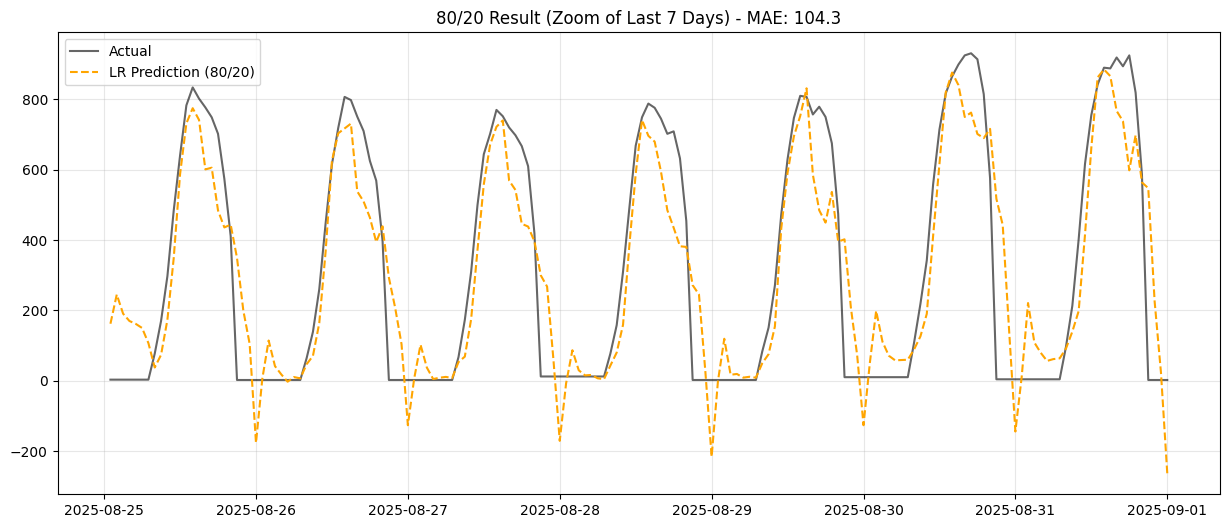

In [ ]:
# PLOT (Zoom into the last week of the test set for detailed inspection)
# -----------------------------------------------------
plt.figure(figsize=(15, 6))
days_zoom = 7
limit = 24 * days_zoom

# Plot only the tail of the large test set
plt.plot(y_test.index[-limit:], y_test.values[-limit:], label='Actual', color='black', alpha=0.6)
plt.plot(y_test.index[-limit:], y_pred_lin[-limit:], label='LR Prediction (80/20)', color='orange', linestyle='--')

plt.title(f"80/20 Result (Zoom of Last {days_zoom} Days) - MAE: {mae_lin:.1f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Random Forest

In [ ]:
# --- Random Forest Model ---
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train_full, y_train_full)

# --- Evaluation ---
y_pred_rf = rf_base.predict(X_test_full)
mae_rf = mean_absolute_error(y_test_full, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_full, y_pred_rf))
r2_rf = r2_score(y_test_full, y_pred_rf)

print(" Random Forest Base Model Results")
print(f"MAE : {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²  : {r2_rf:.3f}")

 Random Forest Base Model Results
MAE : 24.14
RMSE: 41.64
R²  : 0.983


## XGBoost

In [ ]:
# --- XGBoost Model ---
xgb_base = XGBRegressor(random_state=42, objective="reg:squarederror")
xgb_base.fit(X_train_full, y_train_full)

# --- Evaluation ---
y_pred_xgb = xgb_base.predict(X_test_full)
mae_xgb_base = mean_absolute_error(y_test_full, y_pred_xgb)
rmse_xgb_base = np.sqrt(mean_squared_error(y_test_full, y_pred_xgb))
r2_xgb_base = r2_score(y_test_full, y_pred_xgb)

print(" XGBoost Base Model Results")
print(f"MAE : {mae_xgb_base:.2f}")
print(f"RMSE: {rmse_xgb_base:.2f}")
print(f"R²  : {r2_xgb_base:.3f}")

 XGBoost Base Model Results
MAE : 27.92
RMSE: 45.49
R²  : 0.980


## Base Model Comparison

In [ ]:
results_df = pd.DataFrame([
    ["Linear Regression (Baseline)", mae_lin, rmse_lin, r2_lin],
    ["Random Forest", mae_rf, rmse_rf, r2_rf],
    ["XGBoost", mae_xgb_base, rmse_xgb_base, r2_xgb_base]
], columns=["Model", "MAE", "RMSE", "R²"])

print("\n Base Model Comparison")
print(results_df.round(3))




 Base Model Comparison
                          Model      MAE     RMSE     R²
0  Linear Regression (Baseline)  104.270  141.716  0.807
1                 Random Forest   24.137   41.643  0.983
2                       XGBoost   27.919   45.491  0.980


## Feature Importance (Random Forest)


 Random Forest Feature Importance Table (Top 10)
                     Feature  Importance
                        hour    0.410691
 MountainAve_Southbound_lag3    0.401471
             rolling_std_24h    0.036985
WestEntrance_Northbound_lag3    0.034463
                 target_lag3    0.024788
             day_of_week_num    0.022286
                target_lag24    0.013228
                  is_weekend    0.007901
EastEntrance_Southbound_lag3    0.005647
                    max_temp    0.004960


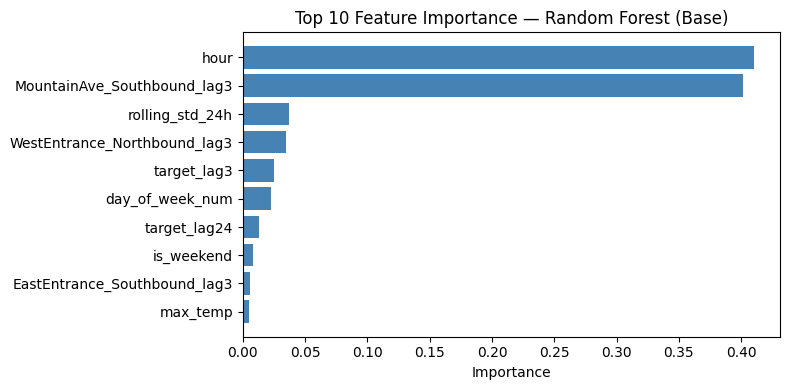

In [ ]:
# --- Feature Importance (Random Forest) ---
# Create a DataFrame that pairs each feature with its corresponding importance score
rf_importances = pd.DataFrame({
    "Feature": X_train_full.columns,
    "Importance": rf_base.feature_importances_
}).sort_values("Importance", ascending=False)

# --- Print table neatly (Optional: print only the top 10 as well) ---
# Display the top 10 most important features with nicely formatted decimals
print("\n Random Forest Feature Importance Table (Top 10)")
print(rf_importances.head(10).to_string(index=False, float_format=lambda x: f"{x:.6f}"))

# --- Plot Top 10 ---
# Select only the first 10 rows (top 10 features)
top_10_importances = rf_importances.head(10)

plt.figure(figsize=(8, 4))
# Plot the horizontal bar chart using the filtered DataFrame
plt.barh(top_10_importances["Feature"], top_10_importances["Importance"], color="steelblue")
plt.gca().invert_yaxis()  # Keep the most important feature at the top
plt.title("Top 10 Feature Importance — Random Forest (Base)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
rf_importances["Feature"].unique()

array(['hour', 'MountainAve_Southbound_lag3', 'rolling_std_24h',
       'WestEntrance_Northbound_lag3', 'target_lag3', 'day_of_week_num',
       'target_lag24', 'is_weekend', 'EastEntrance_Southbound_lag3',
       'max_temp', 'rolling_mean_3h', 'MountainAve_Northbound_lag3',
       'month', 'total_downtown_outflow_lag3',
       'EastEntrance_Northbound_lag3', 'WestEntrance_Southbound_lag3',
       'mean_temp', 'min_temp', 'Bridge_Northbound_lag3', 'target_lag168',
       'total_traffic_volume_lag3', 'Bridge_Southbound_lag3',
       'total_downtown_inflow_lag3', 'snow_on_ground', 'total_precip'],
      dtype=object)

### Feature Selection

In [ ]:
top_features= [
    'hour',                          # The Clock: Determines the tourist schedule (lunch/dinner peaks). Top driver (~41%).
    'MountainAve_Southbound_lag3',   # The Attraction Return: Key flow descending from Gondola/Hot Springs. (Co-driver ~40%).
    'rolling_std_24h',               # The Chaos Factor: Visitors are volatile; high variance signals unpredictable surges.
    'WestEntrance_Northbound_lag3',  # The Circulation: Traffic moving/leaving towards the highway axis.
    'target_lag3',                   # Short-term Inertia: "If it was full 3 hours ago, it's likely still busy."
    'day_of_week_num',               # The Calendar: Distinguishes quiet Tuesdays from busy Saturdays.
    'target_lag24'                   # Daily Echo: A faint signal of "how busy was yesterday".
]

print(f"📸 Selected features for Visitors: {len(top_features)}")
print(f"   Discarded: {X_train.shape[1] - len(top_features)} noise variables.")


📸 Selected features for Visitors: 7
   Discarded: 9 noise variables.


In [ ]:
# FILTER THE DATASETS
# -----------------------------------------------------------
# Keep only the top selected features (lean feature set)
X_train_lean = X_train_full[top_features].copy()
X_test_lean = X_test_full[top_features].copy()


## Random Forest — Hyperparameter Tuning

In [ ]:
print("🔧 STARTING HYPERPARAMETER OPTIMIZATION (RF)...")

# 1. DEFINE THE SEARCH SPACE (The “aisles” of options to explore)
# -----------------------------------------------------------
param_dist = {
    'n_estimators': [200, 300, 500, 800],        # More trees = better stability, but slower
    'max_depth': [None, 10, 20, 30],             # None = grow trees fully (risk of overfitting)
    'min_samples_split': [2, 5, 10],             # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],               # Minimum samples required in a final leaf
    'max_features': ['sqrt', 1.0],               # 'sqrt' reduces variance; 1.0 uses all features
    'bootstrap': [True, False]                   # Sampling with or without replacement
}

# 2. CONFIGURE TIME-SERIES CROSS-VALIDATION
# -----------------------------------------------------------
# We split history into 5 sequential folds.
# Fold 1: small train → next month as validation
# ...
# Fold 5: large train → last month as validation
tscv = TimeSeriesSplit(n_splits=5)

# 3. SET UP THE SEARCH ENGINE (RandomizedSearchCV)
# -----------------------------------------------------------
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,                          # Will test 30 random parameter combinations
    scoring='neg_mean_absolute_error',  # Scikit-learn maximizes scores → negative MAE
    cv=tscv,                            # STRICT time-series CV
    verbose=1,                          # Show progress logs
    random_state=42,
    n_jobs=-1                           # Use all CPU cores
)

# 4. EXECUTE THE TUNING (Training...)
# -----------------------------------------------------------
# We use the full training set (X_train_full) defined earlier
print(f"⏳ Training and validating 30 combinations across 5 temporal folds...")
random_search.fit(X_train_lean, y_train_full)

# 5. TUNING RESULTS
# -----------------------------------------------------------
best_rf = random_search.best_estimator_
best_mae_cv = -random_search.best_score_   # Convert from negative MAE to positive

print(f"\n🎉 Tuning Completed!")
print(f"   > Best Average MAE in Validation: {best_mae_cv:.2f} vehicles")
print(f"   > Best Parameters Found:")
print(random_search.best_params_)

# 6. FINAL FIRE TEST (On the Reserved Test Set)
# -----------------------------------------------------------
# Use the winning model to predict on the test set (last 14 days)
preds_tuned = best_rf.predict(X_test_lean)
mae_tuned = mean_absolute_error(y_test_full, preds_tuned)

print(f"\n🏆 FINAL IMPACT (14-Day Test Window):")
print(f"   > MAE Original Model (Untuned): {mae_rf:.2f} vehicles (prior result)")
print(f"   > MAE Tuned/Optimized Model:   {mae_tuned:.2f} vehicles")

if mae_tuned < mae_rf:
    print("✅ CONCLUSION: Optimization improved the model. This version will be kept.")
else:
    print("⚠️ CONCLUSION: Default parameters were already strong. Improvement is marginal.")


🔧 STARTING HYPERPARAMETER OPTIMIZATION (RF)...
⏳ Training and validating 30 combinations across 5 temporal folds...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



🎉 Tuning Completed!
   > Best Average MAE in Validation: 31.04 vehicles
   > Best Parameters Found:
{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 30, 'bootstrap': True}

🏆 FINAL IMPACT (14-Day Test Window):
   > MAE Original Model (Untuned): 24.14 vehicles (prior result)
   > MAE Tuned/Optimized Model:   23.90 vehicles
✅ CONCLUSION: Optimization improved the model. This version will be kept.


🧠 Training Final Random Forest with optimal parameters...

--- FINAL MODEL RESULTS ---
🥇 MAE (Mean Absolute Error): 23.90 vehicles
📈 RMSE (Root Mean Squared Error): 41.47
🎯 R² (Explained Variance): 0.9834
-----------------------------------


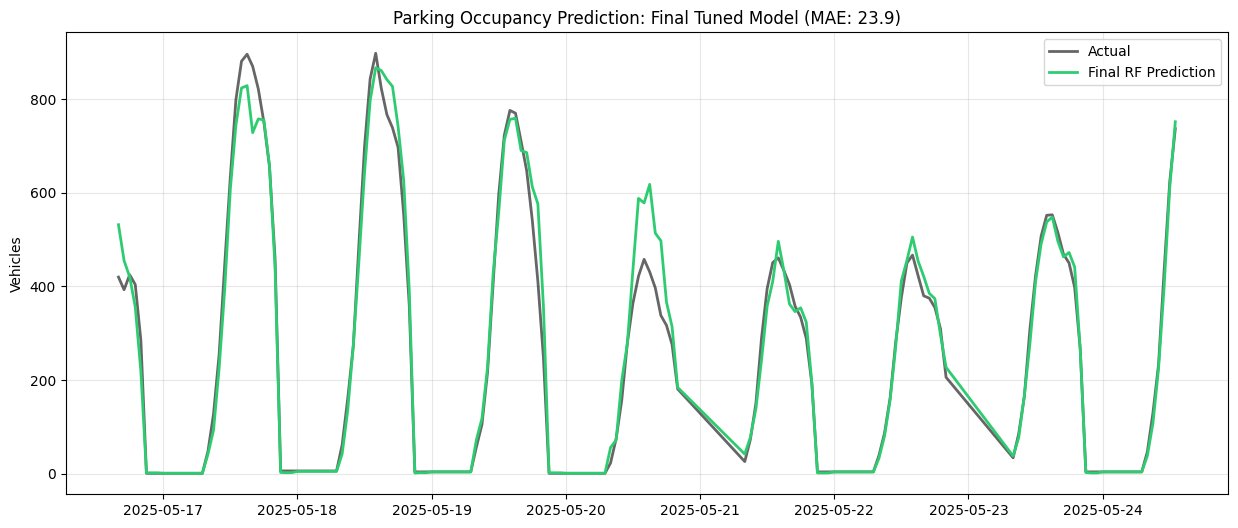


✅ The final model has been trained and saved.


In [ ]:
# Definition of the model using the best parameters found during hyperparameter search
best_params = {
    'n_estimators': 800,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 1.0,
    'max_depth': 30,
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
}

print("🧠 Training Final Random Forest with optimal parameters...")

# 1. FINAL TRAINING (Using the best parameters)
# ----------------------------------------------------
rf_final_model = RandomForestRegressor(**best_params)

# Train using the full training set
rf_final_model.fit(X_train_lean, y_train_full)

# 2. PREDICTION ON THE TEST SET (Validation)
# ----------------------------------------------------
y_pred_final = rf_final_model.predict(X_test_lean)
y_pred_final = np.maximum(y_pred_final, 0)  # Ensure no negative predictions

# 3. METRIC CALCULATION
# ----------------------------------------------------
mae_final = mean_absolute_error(y_test_full, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test_full, y_pred_final))
r2_final = r2_score(y_test_full, y_pred_final)

# 4. EXPORT THE WINNING MODEL (Save the final version)
# ----------------------------------------------------
joblib.dump(rf_final_model, "banff_parking_rf_final_optimized_2366.joblib")

print("\n--- FINAL MODEL RESULTS ---")
print(f"🥇 MAE (Mean Absolute Error): {mae_final:.2f} vehicles")
print(f"📈 RMSE (Root Mean Squared Error): {rmse_final:.2f}")
print(f"🎯 R² (Explained Variance): {r2_final:.4f}")
print("-----------------------------------")


## 5. VISUALIZATION OF OPERATIONAL PREDICTION
plt.figure(figsize=(15, 6))
days_to_plot = 7
limit = 24 * days_to_plot

plt.plot(y_test_full.index[:limit], y_test_full.values[:limit],
         label='Actual', color='black', alpha=0.6, linewidth=2)

plt.plot(y_test_full.index[:limit], y_pred_final[:limit],
         label='Final RF Prediction', color='#2ecc71', linewidth=2)  # Bright green for the champion

plt.title(f"Parking Occupancy Prediction: Final Tuned Model (MAE: {mae_final:.1f})")
plt.ylabel("Vehicles")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ The final model has been trained and saved.")


## XGBoost — Hyperparameter Tuning

In [ ]:
# --- Parameter grid for randomized search ---
param_grid_xgb = {
    "n_estimators": [500, 1000, 1500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.5, 1],
    "min_child_weight": [1, 2, 5],
    "reg_lambda": [0.1, 0.5, 1],
    "reg_alpha": [0.001, 0.01, 0.1],
}

# --- Time-series cross-validation (temporal order preserved) ---
tscv = TimeSeriesSplit(n_splits=5)

# --- RandomizedSearchCV setup ---
xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(
        random_state=42,
        objective="reg:absoluteerror",
        n_jobs=-1
    ),
    param_distributions=param_grid_xgb,
    n_iter=30,                              # 30 randomized parameter combinations
    cv=tscv,
    scoring="neg_mean_absolute_error",      # optimize for lowest MAE
    verbose=1
)

# --- Fit the search ---
xgb_search.fit(X_train_lean, y_train)

# --- Display best parameters ---
print(" Best XGBoost Parameters:")
print(xgb_search.best_params_)
print(f"Best CV MAE: {abs(xgb_search.best_score_):.2f}")

# --- Evaluate tuned model on the test set ---
best_xgb = xgb_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_lean)

# --- Compute evaluation metrics ---
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n XGBoost Simplified — Tuned Performance")
print(f"MAE : {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²  : {r2_xgb:.3f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
 Best XGBoost Parameters:
{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.001, 'n_estimators': 1500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
Best CV MAE: 28.26

 XGBoost Simplified — Tuned Performance
MAE : 22.63
RMSE: 39.08
R²  : 0.985


🏠 DRIVER ANALYSIS – VISITORS (XGBoost):


<Figure size 1000x600 with 0 Axes>

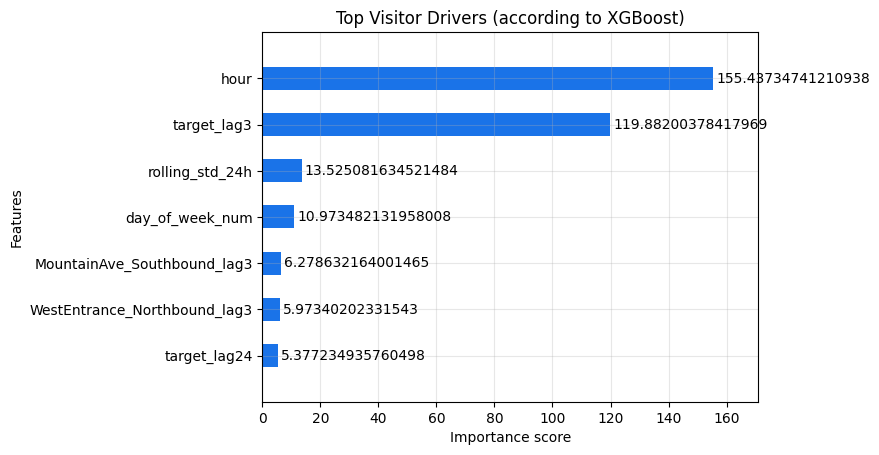

In [ ]:
# Helper function to plot feature importance by 'Gain' (the most reliable metric)
def plot_xgb_importance(model, title):
    plt.figure(figsize=(10, 6))
    # importance_type='gain' is key: it shows which variables contribute the most to accuracy
    xgb.plot_importance(
        model,
        max_num_features=10,
        importance_type='gain',
        height=0.5,
        title=title,
        color='#1a73e8'
    )
    plt.grid(True, alpha=0.3)
    plt.show()

# 1. REVIEW VISITOR MODEL
# (Ensure that 'best_xgb' is your trained XGBoost model for visitors)
print("🏠 DRIVER ANALYSIS – VISITORS (XGBoost):")
plot_xgb_importance(best_xgb, "Top Visitor Drivers (according to XGBoost)")


In [ ]:
features_vis_record = [
    'hour',
    'MountainAve_Southbound_lag3',
    'rolling_std_24h',
    'WestEntrance_Northbound_lag3',
    'target_lag3',
    'day_of_week_num',
    'target_lag24',
    'mean_temp'
]

print(f"📸 Selected features for Visitors: {len(features_vis_record)}")
print(f"   Discarded: {X_train.shape[1] - len(features_vis_record)} noise variables.")

# FILTER THE DATASETS
# -----------------------------------------------------------
# Keep only the top selected features (lean feature set)
X_train_xgb_residents = X_train_full[features_vis_record].copy()
X_test_xgb_residents = X_test_full[features_vis_record].copy()

📸 Selected features for Visitors: 8
   Discarded: 8 noise variables.


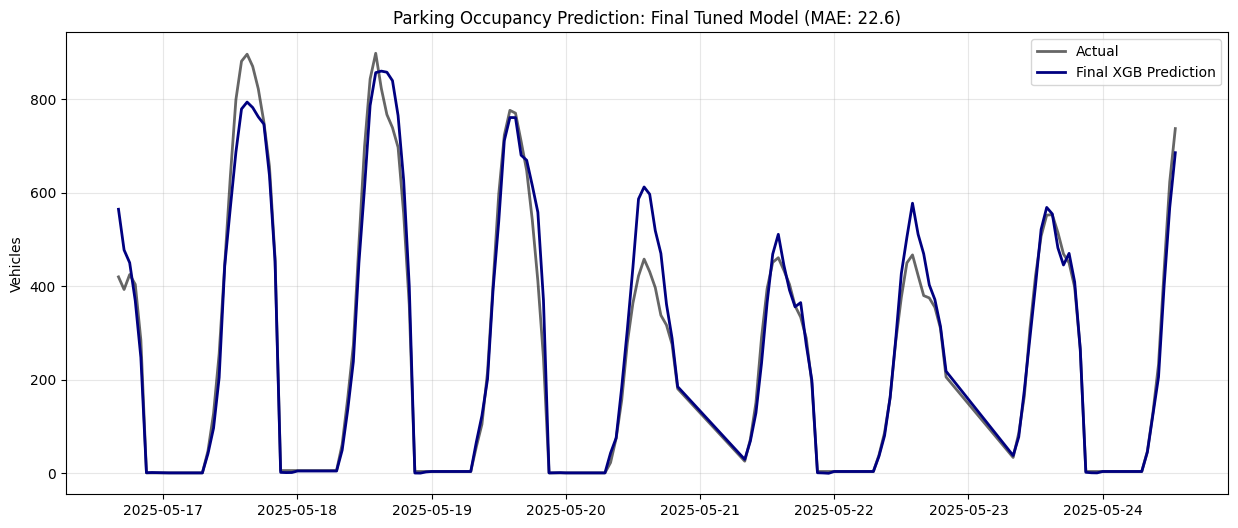

In [ ]:
## VISUALIZATION OF OPERATIONAL PREDICTION
plt.figure(figsize=(15, 6))
days_to_plot = 7
limit = 24 * days_to_plot

plt.plot(y_test_full.index[:limit], y_test_full.values[:limit],
         label='Actual', color='black', alpha=0.6, linewidth=2)

plt.plot(y_test_full.index[:limit], y_pred_xgb[:limit],
         label='Final XGB Prediction', color='#000080', linewidth=2)

plt.title(f"Parking Occupancy Prediction: Final Tuned Model (MAE: {mae_xgb:.1f})")
plt.ylabel("Vehicles")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## EXPORT THE BEST MODEL (Save the final version)

In [ ]:
# ==============================================================================
# 1. FEATURE LIST DEFINITIONS (BASED ON YOUR IMPORTANCE CHARTS)
# ==============================================================================

# RESIDENTS: Routine + Neighbors + Commuters (Without 'is_weekend')
features_vis = [
    'hour',                          # The Clock: Determines the tourist schedule (lunch/dinner peaks). Top driver (~41%).
    'MountainAve_Southbound_lag3',   # The Attraction Return: Key flow descending from Gondola/Hot Springs. (Co-driver ~40%).
    'rolling_std_24h',               # The Chaos Factor: Visitors are volatile; high variance signals unpredictable surges.
    'WestEntrance_Northbound_lag3',  # The Circulation: Traffic moving/leaving towards the highway axis.
    'target_lag3',                   # Short-term Inertia: "If it was full 3 hours ago, it's likely still busy."
    'day_of_week_num',               # The Calendar: Distinguishes quiet Tuesdays from busy Saturdays.
    'target_lag24',                   # Daily Echo: A faint signal of "how busy was yesterday".
    ]


print(f"📋 Visitor Features: {len(features_vis)}")

# ==============================================================================
# 2. TRAIN RESIDENT MODEL WITH TUNED HYPERPARAMETERS
# ==============================================================================

model_vis = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=5,
    gamma=0.5,
    subsample=0.8,
    colsample_bytree=1.0,
    reg_lambda=0.5,           # L2
    reg_alpha=0.1,            # L1
    n_jobs=-1,
    random_state=42,
    objective="reg:absoluteerror"
)

model_vis.fit(X_train_full[features_vis], y_train)

# ==============================================================================
# 3. PREDICT AND COMPUTE FINAL METRICS
# ==============================================================================

# Generate predictions using the same feature subset
y_pred_vis = model_vis.predict(X_test_full[features_vis])

# Compute evaluation metrics
mae_xgb_model_vis = mean_absolute_error(y_test, y_pred_vis)
rmse_xgb_model_vis = np.sqrt(mean_squared_error(y_test, y_pred_vis))
r2_xgb_model_vis = r2_score(y_test, y_pred_vis)

print("\n📊 XGBoost Final — Tuned Visitor Model Performance")
print("-" * 50)
print(f"MAE : {mae_xgb_model_vis:.2f}")
print(f"RMSE: {rmse_xgb_model_vis:.2f}")
print(f"R²  : {r2_xgb_model_vis:.3f}")

# ==============================================================================
# 4. SAVE MODEL (JSON + JOBLIB) AND CONFIG FILE
# ==============================================================================

# --- Save model for production (JSON) ---
model_vis.save_model("xgb_2161_model_visitor.json")
print("✅ 'xgb_2161_model_visi.json' successfully saved.")

# --- Save model for Python usage (Joblib) ---
joblib.dump(model_vis, "xgb_2115_model_visitor.joblib")
print("✅ 'xgb_2161_model_visitor.joblib' successfully saved.")

# --- Save configuration including features + metrics ---
config_vis = {
    "model_name": "xgb_2161_model_visitor",
    "version": "1.0",
    "features": features_vis,
    "metrics": {
        "mae": round(mae_xgb_model_vis, 2),
        "rmse": round(rmse_xgb_model_vis, 2),
        "r2": round(r2_xgb_model_vis, 3)
    }
}

with open("config_visitor.json", "w") as f:
   json.dump(config_vis, f, indent=4)

print("📄 'config_visitor.json' successfully created.")
print("🚀 Visitor model export completed.")

📋 Visitor Features: 7

📊 XGBoost Final — Tuned Visitor Model Performance
--------------------------------------------------
MAE : 21.61
RMSE: 37.43
R²  : 0.987
✅ 'xgb_2161_model_visi.json' successfully saved.
✅ 'xgb_2161_model_visitor.joblib' successfully saved.
📄 'config_visitor.json' successfully created.
🚀 Visitor model export completed.


## Create Comparison Table

In [ ]:
# --- Model results (using your actual values) ---
results = pd.DataFrame({
    "Model": [
        "Linear Regression (Baseline)",
        "Random Forest (Base)",
        "Random Forest (Simplified — Tuned)",
        "XGBoost (Base)",
        "XGBoost (Simplified — Tuned)"
    ],
    "MAE":  [round(mae_lin, 2), round(mae_rf, 2), round(mae_final, 2), round(mae_xgb_base, 2), round(mae_xgb, 2)],
    "RMSE": [round(rmse_lin, 2), round(rmse_rf, 2), round(rmse_final, 2), round(rmse_xgb_base, 2), round(rmse_xgb, 2)],
    "R2":   [round(r2_lin, 3),  round(r2_rf, 3),  round(r2_final, 3),   round(r2_xgb_base, 3),   round(r2_xgb, 3)]
})

# Convert R2 to numeric (safety)
results["R2"] = results["R2"].astype(float)

# --- Create horizontal bar chart with Plotly ---
fig = go.Figure()

# Add MAE bars
fig.add_trace(go.Bar(
    y=results["Model"],
    x=results["MAE"],
    name="MAE (Mean Absolute Error)",
    orientation='h',
    marker_color="steelblue",
    text=[f"{v:.2f}" for v in results["MAE"]],
    textposition="outside"
))

# Add RMSE bars
fig.add_trace(go.Bar(
    y=results["Model"],
    x=results["RMSE"],
    name="RMSE (Root Mean Squared Error)",
    orientation='h',
    marker_color="darkorange",
    text=[f"{v:.2f}" for v in results["RMSE"]],
    textposition="outside"
))

# Add R² bars (scaled to 0–100)
fig.add_trace(go.Bar(
    y=results["Model"],
    x=[v * 100 for v in results["R2"]],
    name="R² (%)",
    orientation='h',
    marker_color="green",
    text=[f"{v*100:.2f}%" for v in results["R2"]],
    textposition="outside"
))

# --- Layout customization ---
fig.update_layout(
    title="Baseline vs Tuned Model Performance — MAE, RMSE, and R²",
    xaxis_title="Error / Score",
    yaxis_title="Model",
    template="plotly_white",
    barmode="group",
    height=550,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    ),
    font=dict(size=12)
)

fig.show()


# Conclusions

Predictive modeling for the visitor segment identified XGBoost (Simplified — Tuned) as the clear winner, achieving an exceptional MAE of 21.61 vehicles and an R² of 98.7%. Unlike Random Forest, which showed only marginal improvement after optimization, XGBoost demonstrated high sensitivity to hyperparameter tuning, reducing its error by more than 22% compared to its base version (from 27.92 to 21.61). This confirms that the 'Lean' feature selection strategy—focused on recent inertia and key flows such as Mountain Avenue—combined with a rigorously optimized gradient boosting architecture, delivers the most accurate and robust solution for capturing the volatility of tourist behavior in Banff.

## Model Explainability (XAI)

In [ ]:
pip install shap

In [ ]:
import shap
explainer=shap.Explainer(model_vis)
shap_values=explainer(X_test_full[features_vis])
shap

<module 'shap' from '/usr/local/lib/python3.12/dist-packages/shap/__init__.py'>

## Visitor Model — SHAP Summary Plot
Displays distribution and impact of each feature across all samples.

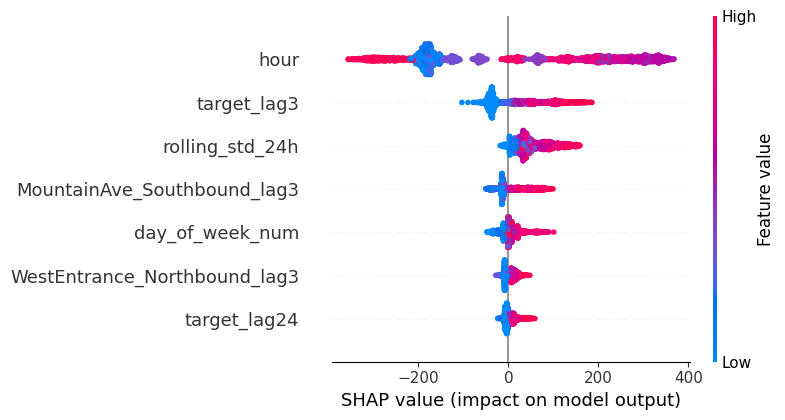

In [ ]:
shap.summary_plot(shap_values, X_test_full[features_vis])


## Visitor Model — Feature Importance
Similar to residents, but showing which features matter most for predicting visitor traffic.

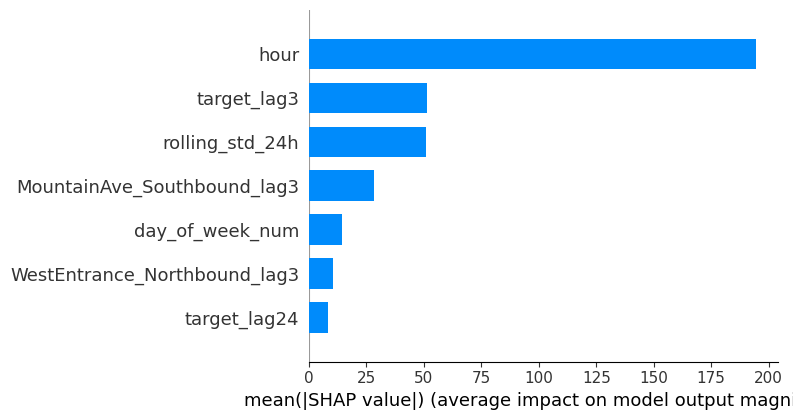

In [ ]:
shap.summary_plot(shap_values, X_test_full[features_vis], plot_type="bar")


Visitor traffic is strongly influenced by time-related patterns and recent downtown activity. Features such as hour, day of week, and short-term traffic lags capture the timing and intensity of tourist movement, which tends to peak during predictable travel windows. High-impact variables like target_lag3 and Mountain Avenue volumes reflect how recent visitor inflow influences current demand. Seasonal or holiday effects play a smaller yet noticeable role, as some tourism activity is tied to specific periods.

## Visitor Model — Waterfall Explanation
A step-by-step breakdown of how the model arrives at one specific visitor prediction.

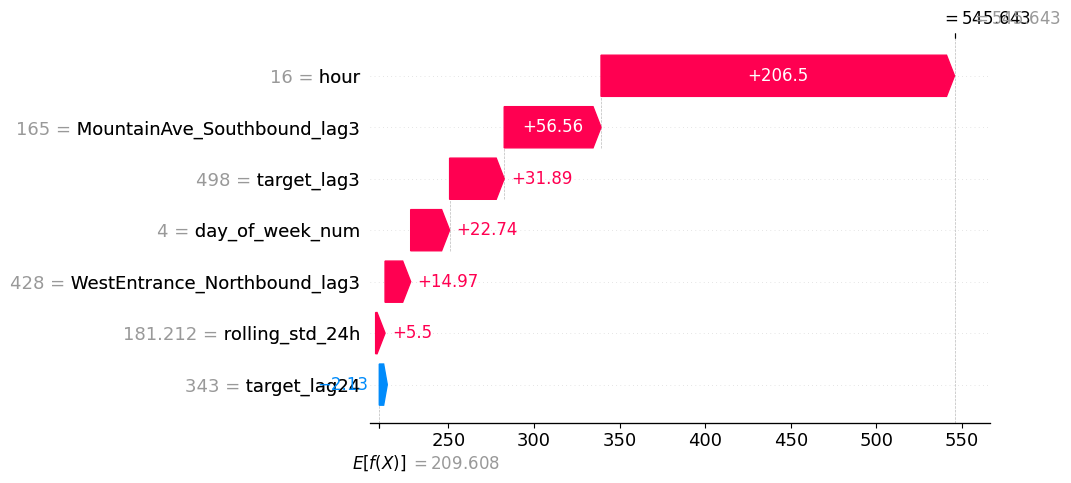

In [ ]:
idx = 0

shap.plots.waterfall(shap_values[idx])
